<a href="https://colab.research.google.com/github/alaahossam/Speech-Emotion-Recognition/blob/master/Speech_Emotion_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Speech Emotion Recognition

## Importing Libraries

In [ ]:
! pip install audiomentations

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import pandas as pd
import os.path
from scipy.io import wavfile
import librosa
import soundfile
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,StandardScaler,MinMaxScaler
from sklearn.metrics import confusion_matrix,f1_score,accuracy_score
from audiomentations import Compose, AddGaussianNoise, TimeStretch, PitchShift, Shift, Gain,SpecCompose, SpecChannelShuffle, SpecFrequencyMask
import tensorflow as tf
from keras import utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Conv1D, MaxPooling1D, Conv2D, MaxPooling2D, Flatten, BatchNormalization
from keras import optimizers,regularizers

## Preprocessing Data

### Loading Dataset

In [ ]:
#kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Listing the audios files in array (only thier names)

In [ ]:
#path = '../input/speech-emotion-recognition-en/Crema'
path = '/content/drive/MyDrive/Crema'

files = []

for file in os.listdir(path):
    if file.endswith('.wav'):
        files.append(os.path.join(path, file))

#print(len(files))
#for i in range(5):
#    print(files[i])
#print("\n")    

labels = []

for file in files:
    label = os.path.splitext(os.path.split(file)[1])[0].split('_')[2]
    labels.append(label)
    
print(len(labels))
print(set(labels))    
dict_label={"HAP": "Happy", "ANG": "Anger", "SAD":"Sad", "NEU":"Neutral","DIS":"Disgust", "FEA":"Fear" }

7451
{'HAP', 'NEU', 'SAD', 'DIS', 'ANG', 'FEA'}


### loading the raw data of eadh audio in array

In [ ]:
audios = []

for i in files:
    audio, sr = librosa.load(i, sr= None)
    audios.append(audio)

print(len(audios))
print(len(audios[0]))
for i in range(5):
    print(audios[i])    

7451
36303
[-1.3916016e-02 -1.5411377e-02 -1.4587402e-02 ... -9.1552734e-05
  3.0517578e-05 -6.1035156e-05]
[0.00567627 0.00515747 0.00448608 ... 0.         0.         0.        ]
[-0.00027466 -0.00018311  0.00024414 ...  0.          0.
  0.        ]
[ 0.00100708  0.00045776 -0.00033569 ...  0.          0.
  0.        ]
[ 0.00024414 -0.00039673 -0.00045776 ...  0.          0.
  0.        ]


### Audio padding

To overcome the problem that the audios are nor the same length, we get the max audio length in the data and make padding for all the audios that have less length 

In [ ]:
max_length = max(len(audio) for audio in audios)

padded_audios = []
for audio in audios:
    padding = max_length - len(audio)
    padded_audio = np.pad(audio, (0, padding), mode='constant')
    padded_audios.append(padded_audio)

print(len(padded_audios))
print(len(padded_audios[0]))
for i in range(5):
    print(padded_audios[i])   

7451
80080
[-0.01391602 -0.01541138 -0.0145874  ...  0.          0.
  0.        ]
[0.00567627 0.00515747 0.00448608 ... 0.         0.         0.        ]
[-0.00027466 -0.00018311  0.00024414 ...  0.          0.
  0.        ]
[ 0.00100708  0.00045776 -0.00033569 ...  0.          0.
  0.        ]
[ 0.00024414 -0.00039673 -0.00045776 ...  0.          0.
  0.        ]


### Plotting Label Counts

This plot shows the number of audios of each label.

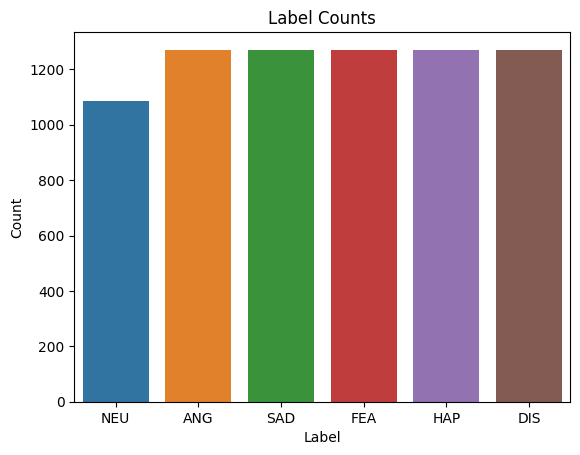

In [ ]:
sns.countplot(x=labels)
plt.title("Label Counts")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Plotting Raw Signal of Different Audios

This function plots the spectrum of the different types of audios.

In [ ]:
def plot_audio(start):
  for label in dict_label.keys():
    audio_num=labels.index(label,start)
    fig=plt.figure()
    plt.plot(audios[audio_num])
    fig.suptitle(str(dict_label[labels[audio_num]]+" Audio"))
    plt.xlabel("t")
    plt.ylabel("f(t)")
    plt.show()

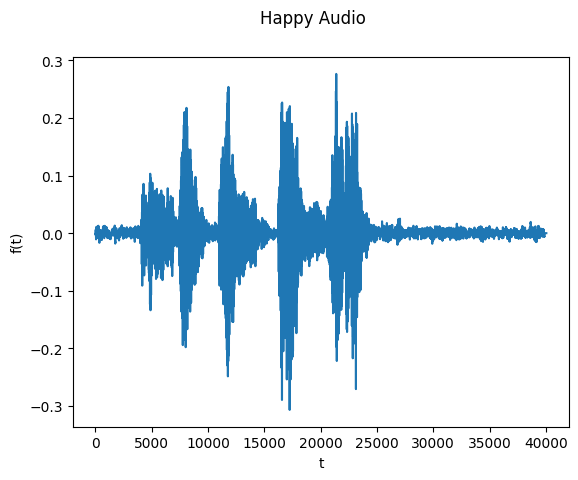

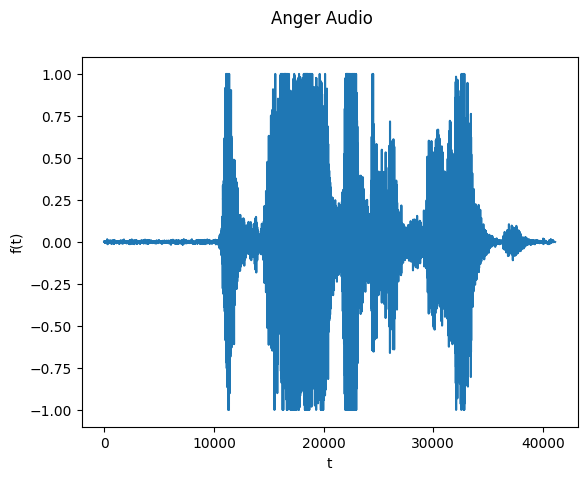

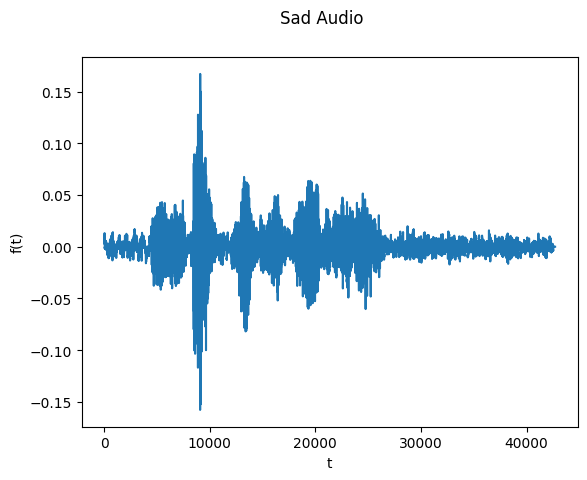

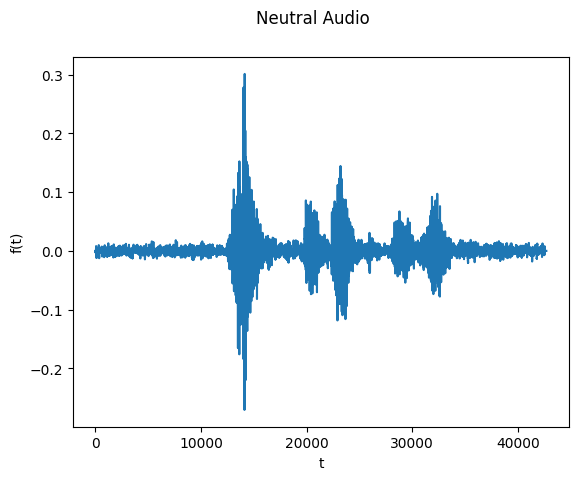

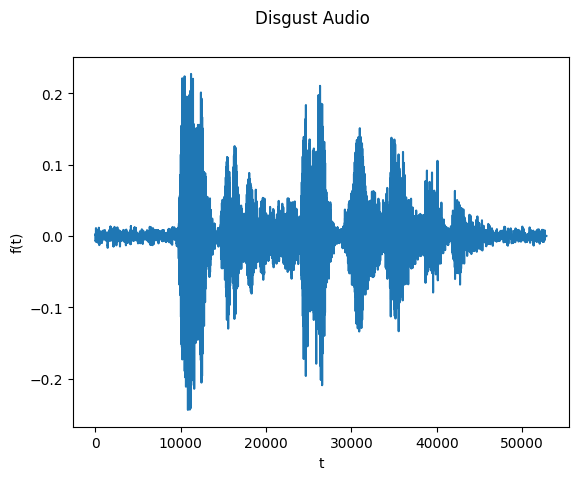

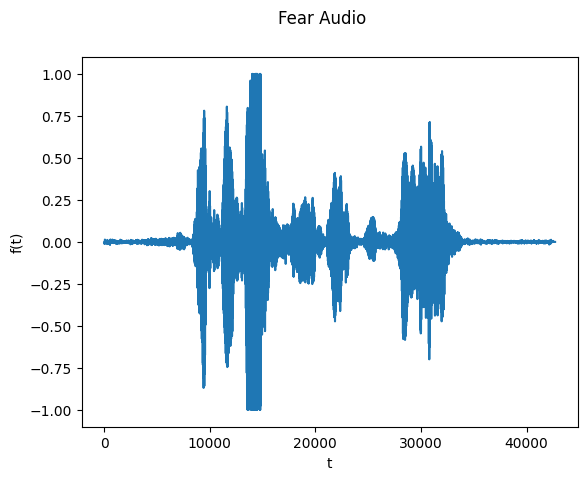

In [ ]:
plot_audio(0)

### Playing Audios

This function makes you able to display the audio according to the label(happiness, anger, fear, neuteral , sad, disgust and so on) and the index of the audio.

In [ ]:
def play_audio(label,x):
  i=labels.index(label,x)
  print(dict_label[label]+" Audio")
  return ipd.Audio(files[i])

In [ ]:
play_audio("HAP",20)

Happy Audio


In [ ]:
play_audio("DIS",10)

Disgust Audio


In [ ]:
play_audio("ANG",30)

Anger Audio


In [ ]:
play_audio("SAD",60)

Sad Audio


In [ ]:
play_audio("FEA",60)

Fear Audio


In [ ]:
play_audio("SAD",50)

Sad Audio


In [ ]:
play_audio("HAP",60)

Happy Audio


In [ ]:
play_audio("FEA",70)

Fear Audio


In [ ]:
play_audio("NEU",10)

Neutral Audio


In [ ]:
play_audio("ANG",90)

Anger Audio


In [ ]:
play_audio("ANG",900)

Anger Audio


### Encoding Labels

Encoding the categorical data (labels).

In [ ]:
y = np.array(labels)
y = y.reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
encoder.fit(y)

y = encoder.transform(y)
#print(set(y))
print(y.shape)

(7451, 6)


### Splitting Data

Splitting the data into train and test sets.

In [ ]:
X_train_val, X_test, y_train_val, y_test = train_test_split(np.asarray(padded_audios), y, test_size=0.3, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.05, random_state=42, stratify = y_train_val)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print(X_val.shape)
print(y_val.shape)

(4954, 80080)
(4954, 6)
(2236, 80080)
(2236, 6)
(261, 80080)
(261, 6)


### Data Augmentation

This part to be used in 2D model to enhance the accuracy and training of the model but colab ram is crashed to we didn't use it unfortunately.

In [ ]:
augmentation = Compose([AddGaussianNoise(p=0.5), 
                        TimeStretch(p=0.5),
                        PitchShift(p=0.5),
                        Shift(p=0.5)])

In [ ]:
augmented_audios = []
for audio in X_train:
    augmented_audio = augmentation(samples=audio, sample_rate=sr)
    augmented_audios.append(augmented_audio)
augmented_audios= np.array(augmented_audios)    
print(augmented_audios.shape)    

In [ ]:
y_train = np.repeat(y_train, len(augmented_audios))
X_train = np.concatenate((padded_audios,augmented_audios),axis=0)

print(X_train.shape)
print(y.shape) 

### Extracting Features

#### Frequency Domain

Extracting feartues from frequency domain.

##### MFCCs

In [ ]:
train_mfcc =  []

for audio in X_train:
    mfccs = np.mean(librosa.feature.mfcc(y=audio),axis= 0)
    train_mfcc.append(mfccs)

#train_mfcc = np.squeeze(np.array(train_mfcc), axis=1)
train_mfcc = np.expand_dims(train_mfcc, -1)
print(train_mfcc.shape)

test_mfcc =  []

for audio in X_test:
    mfccs = np.mean(librosa.feature.mfcc(y=audio),axis= 0)
    test_mfcc.append(mfccs)

#test_mfcc = np.squeeze(np.array(test_mfcc), axis=1)
test_mfcc = np.expand_dims(test_mfcc, -1)
print(test_mfcc.shape)

val_mfcc =  []

for audio in X_val:
    mfccs = np.mean(librosa.feature.mfcc(y=audio),axis= 0)
    val_mfcc.append(mfccs)

#val_mfcc = np.squeeze(np.array(val_mfcc), axis=1)
val_mfcc = np.expand_dims(val_mfcc, -1)
print(val_mfcc.shape)

(4948, 157, 1)
(2233, 157, 1)
(261, 157, 1)


##### Spectral Roll-off

In [ ]:
train_sr =  []

for audio in X_train:
    srf = librosa.feature.spectral_rolloff(y=audio)
    train_sr.append(srf)

train_sr = np.squeeze(np.array(train_sr), axis=1)
train_sr = np.expand_dims(train_sr, -1)
print(train_sr.shape)

test_sr =  []

for audio in X_test:
    srf = librosa.feature.spectral_rolloff(y=audio)
    test_sr.append(srf)

test_sr = np.squeeze(np.array(test_sr), axis=1)
test_sr = np.expand_dims(test_sr, -1)
print(test_sr.shape)

val_sr =  []

for audio in X_val:
    srf = librosa.feature.spectral_rolloff(y=audio)
    val_sr.append(srf)

val_sr = np.squeeze(np.array(val_sr), axis=1)
val_sr = np.expand_dims(val_sr, -1)
print(val_sr.shape)

(4948, 157, 1)
(2233, 157, 1)
(261, 157, 1)


#### Time Domain

Extracting features from Time domain.

##### Energy

In [ ]:
train_energy =  []

for audio in X_train:
    energy = librosa.feature.rms(y=audio)
    train_energy.append(energy)

train_energy = np.squeeze(np.array(train_energy), axis=1)
train_energy = np.expand_dims(train_energy, -1)
print(train_energy.shape)

test_energy =  []

for audio in X_test:
    energy = librosa.feature.rms(y=audio)
    test_energy.append(energy)

test_energy = np.squeeze(np.array(test_energy), axis=1)
test_energy = np.expand_dims(test_energy, -1)
print(test_energy.shape)

val_energy =  []

for audio in X_val:
    energy = librosa.feature.rms(y=audio)
    val_energy.append(energy)

val_energy = np.squeeze(np.array(val_energy), axis=1)
val_energy = np.expand_dims(val_energy, -1)
print(val_energy.shape)

(4954, 157, 1)
(2236, 157, 1)
(261, 157, 1)


##### Zero Crossing Rate

In [ ]:
train_zcr =  []

for audio in X_train:
    zcr = librosa.feature.zero_crossing_rate(audio)
    train_zcr.append(zcr)

train_zcr = np.squeeze(np.array(train_zcr), axis=1)
train_zcr = np.expand_dims(train_zcr, -1)
print(train_zcr.shape)

test_zcr =  []

for audio in X_test:
    zcr = librosa.feature.zero_crossing_rate(audio)
    test_zcr.append(zcr)

test_zcr = np.squeeze(np.array(test_zcr), axis=1)
test_zcr = np.expand_dims(test_zcr, -1)
print(test_zcr.shape)

val_zcr =  []

for audio in X_val:
    zcr = librosa.feature.zero_crossing_rate(audio)
    val_zcr.append(zcr)

val_zcr = np.squeeze(np.array(val_zcr), axis=1)
val_zcr = np.expand_dims(val_zcr, -1)
print(val_zcr.shape)

(4954, 157, 1)
(2236, 157, 1)
(261, 157, 1)


#### Mel Spectrogram

In [ ]:
train_mel = []

for audio in X_train:
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    train_mel.append(mel_spec)
    
train_mel = np.array(train_mel)
train_mel = np.expand_dims(train_mel, -1)
print(train_mel.shape)

test_mel = []

for audio in X_test:
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    test_mel.append(mel_spec)
    
test_mel = np.array(test_mel)
test_mel = np.expand_dims(test_mel, -1)
print(test_mel.shape)

val_mel = []

for audio in X_val:
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=sr)
    mel_spec = librosa.power_to_db(mel_spec, ref=np.max)
    val_mel.append(mel_spec)
    
val_mel = np.array(val_mel)
val_mel = np.expand_dims(val_mel, -1)
print(val_mel.shape)

(4954, 128, 157, 1)
(2236, 128, 157, 1)
(261, 128, 157, 1)


Plotting of spectrogram.

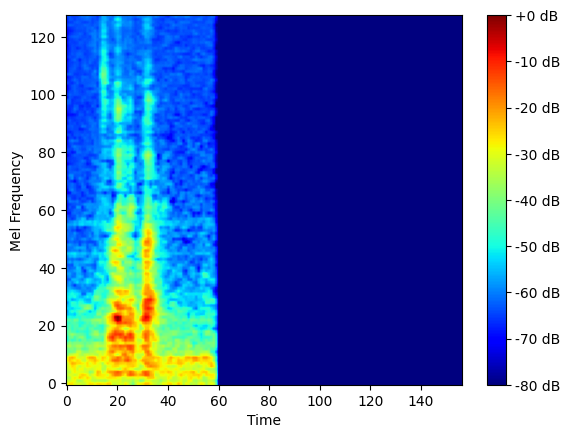

In [ ]:
plt.imshow(mel_spec, aspect='auto', origin='lower', cmap='jet')
plt.colorbar(format='%+2.0f dB')
plt.xlabel('Time')
plt.ylabel('Mel Frequency')
plt.show()

## CNN Models

### Model 1D - Energy

Testing 1D model with energy feature only.

#### Building Model

In [ ]:
model = Sequential()
model.add(Conv1D(16, 12, activation='relu', input_shape=(train_energy.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 146, 16)           208       
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, 73, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_13 (Conv1D)          (None, 66, 24)            3096      
                                                                 
 max_pooling1d_13 (MaxPoolin  (None, 33, 24)           0         
 g1D)                                                            
                                                                 
 conv1d_14 (Conv1D)          (None, 29, 24)            2904      
                                                                 
 max_pooling1d_14 (MaxPoolin  (None, 14, 24)          

In [ ]:
history = model.fit(train_energy, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(val_energy, y_val))

Epoch 1/50
39/39 [==============================] - 2s 28ms/step - loss: 1.7254 - accuracy: 0.2084 - val_loss: 1.6094 - val_accuracy: 0.2874
Epoch 2/50
39/39 [==============================] - 1s 23ms/step - loss: 1.5927 - accuracy: 0.3145 - val_loss: 1.4802 - val_accuracy: 0.3870
Epoch 3/50
39/39 [==============================] - 1s 22ms/step - loss: 1.5160 - accuracy: 0.3608 - val_loss: 1.4089 - val_accuracy: 0.4444
Epoch 4/50
39/39 [==============================] - 1s 24ms/step - loss: 1.4870 - accuracy: 0.3895 - val_loss: 1.3773 - val_accuracy: 0.4751
Epoch 5/50
39/39 [==============================] - 1s 22ms/step - loss: 1.4643 - accuracy: 0.4000 - val_loss: 1.3642 - val_accuracy: 0.4828
Epoch 6/50
39/39 [==============================] - 1s 22ms/step - loss: 1.4571 - accuracy: 0.4052 - val_loss: 1.3585 - val_accuracy: 0.4713
Epoch 7/50
39/39 [==============================] - 1s 21ms/step - loss: 1.4477 - accuracy: 0.4084 - val_loss: 1.3491 - val_accuracy: 0.4943
Epoch 8/50
39

#### Evaluating Model

In [ ]:
y_pred = model.predict(test_energy)
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 0s 3ms/step


Acurracy score = 0.44872369010300045


F1 score (macro average) = 0.436351352454696


F1 score (weighted average) = 0.43693261772795944


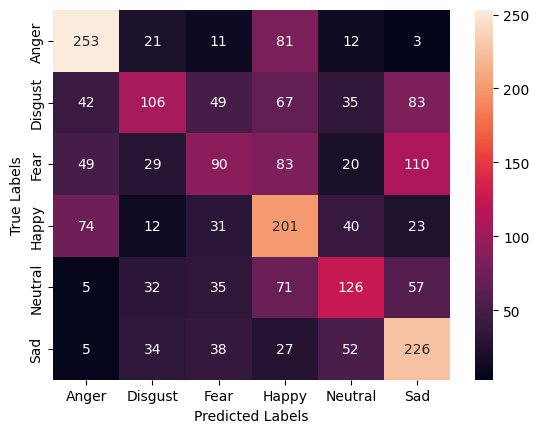

In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - FEA:
	F1-score = 0.2835	Precision = 0.3543	Recall = 0.2362 
2 - DIS:
	F1-score = 0.3442	Precision = 0.4530	Recall = 0.2775 
3 - NEU:
	F1-score = 0.4124	Precision = 0.4421	Recall = 0.3865 
4 - HAP:
	F1-score = 0.4413	Precision = 0.3792	Recall = 0.5276 
5 - SAD:
	F1-score = 0.5113	Precision = 0.4502	Recall = 0.5916 
6 - ANG:
	F1-score = 0.6255	Precision = 0.5911	Recall = 0.6640 


### Model 1D - Zero Crossing Rate

Testing 1D model with Zero crossing rate feature only.

#### Building Model

In [ ]:
model = Sequential()
model.add(Conv1D(16, 12, activation='relu', input_shape=(train_zcr.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_15 (Conv1D)          (None, 146, 16)           208       
                                                                 
 max_pooling1d_15 (MaxPoolin  (None, 73, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_16 (Conv1D)          (None, 66, 24)            3096      
                                                                 
 max_pooling1d_16 (MaxPoolin  (None, 33, 24)           0         
 g1D)                                                            
                                                                 
 conv1d_17 (Conv1D)          (None, 29, 24)            2904      
                                                                 
 max_pooling1d_17 (MaxPoolin  (None, 14, 24)          

In [ ]:
history = model.fit(train_zcr, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(val_zcr, y_val))

Epoch 1/50
39/39 [==============================] - 2s 29ms/step - loss: 1.7773 - accuracy: 0.1789 - val_loss: 1.7373 - val_accuracy: 0.1954
Epoch 2/50
39/39 [==============================] - 1s 22ms/step - loss: 1.7441 - accuracy: 0.2591 - val_loss: 1.6983 - val_accuracy: 0.2414
Epoch 3/50
39/39 [==============================] - 1s 20ms/step - loss: 1.7107 - accuracy: 0.2801 - val_loss: 1.6455 - val_accuracy: 0.3142
Epoch 4/50
39/39 [==============================] - 1s 20ms/step - loss: 1.6579 - accuracy: 0.3173 - val_loss: 1.5946 - val_accuracy: 0.3678
Epoch 5/50
39/39 [==============================] - 1s 19ms/step - loss: 1.6157 - accuracy: 0.3426 - val_loss: 1.5881 - val_accuracy: 0.3525
Epoch 6/50
39/39 [==============================] - 1s 21ms/step - loss: 1.5925 - accuracy: 0.3482 - val_loss: 1.5510 - val_accuracy: 0.3563
Epoch 7/50
39/39 [==============================] - 1s 21ms/step - loss: 1.5815 - accuracy: 0.3498 - val_loss: 1.5439 - val_accuracy: 0.3755
Epoch 8/50
39

#### Evaluating Model

In [ ]:
y_pred = model.predict(test_zcr)
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 0s 3ms/step


Acurracy score = 0.39632781012091356


F1 score (macro average) = 0.38286335100423435


F1 score (weighted average) = 0.38328540496165664


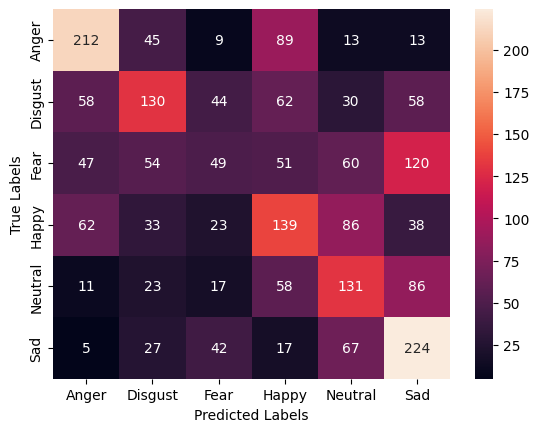

In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - FEA:
	F1-score = 0.1735	Precision = 0.2663	Recall = 0.1286 
2 - HAP:
	F1-score = 0.3488	Precision = 0.3341	Recall = 0.3648 
3 - NEU:
	F1-score = 0.3675	Precision = 0.3385	Recall = 0.4018 
4 - DIS:
	F1-score = 0.3746	Precision = 0.4167	Recall = 0.3403 
5 - SAD:
	F1-score = 0.4864	Precision = 0.4156	Recall = 0.5864 
6 - ANG:
	F1-score = 0.5464	Precision = 0.5367	Recall = 0.5564 


### Model 1D - Energy and Zero Crossing Rate

This model gave us the best results, with accuracy reaching 48%.

#### Building Model

In [ ]:
model = Sequential()
model.add(Conv1D(16, 12, activation='relu', input_shape=((np.concatenate((train_energy, train_zcr), axis=1)).shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_18 (Conv1D)          (None, 303, 16)           208       
                                                                 
 max_pooling1d_18 (MaxPoolin  (None, 151, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_19 (Conv1D)          (None, 144, 24)           3096      
                                                                 
 max_pooling1d_19 (MaxPoolin  (None, 72, 24)           0         
 g1D)                                                            
                                                                 
 conv1d_20 (Conv1D)          (None, 68, 24)            2904      
                                                                 
 max_pooling1d_20 (MaxPoolin  (None, 34, 24)          

In [ ]:
history = model.fit(np.concatenate((train_energy, train_zcr), axis=1), y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(np.concatenate((val_energy, val_zcr), axis=1), y_val))

Epoch 1/50
39/39 [==============================] - 2s 37ms/step - loss: 1.7090 - accuracy: 0.2387 - val_loss: 1.5530 - val_accuracy: 0.3372
Epoch 2/50
39/39 [==============================] - 1s 31ms/step - loss: 1.5649 - accuracy: 0.3482 - val_loss: 1.4812 - val_accuracy: 0.3946
Epoch 3/50
39/39 [==============================] - 1s 33ms/step - loss: 1.5159 - accuracy: 0.3804 - val_loss: 1.3936 - val_accuracy: 0.4789
Epoch 4/50
39/39 [==============================] - 1s 33ms/step - loss: 1.4814 - accuracy: 0.3931 - val_loss: 1.3811 - val_accuracy: 0.4100
Epoch 5/50
39/39 [==============================] - 1s 35ms/step - loss: 1.4526 - accuracy: 0.4095 - val_loss: 1.3580 - val_accuracy: 0.4751
Epoch 6/50
39/39 [==============================] - 1s 36ms/step - loss: 1.4331 - accuracy: 0.4163 - val_loss: 1.3452 - val_accuracy: 0.4598
Epoch 7/50
39/39 [==============================] - 1s 35ms/step - loss: 1.4296 - accuracy: 0.4224 - val_loss: 1.3220 - val_accuracy: 0.4674
Epoch 8/50
39

#### Evaluating Model

In [ ]:
y_pred = model.predict(np.concatenate((test_energy, test_zcr), axis=1))
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 0s 6ms/step


Acurracy score = 0.48141513658755036


F1 score (macro average) = 0.47466678367205245


F1 score (weighted average) = 0.4745046872848074


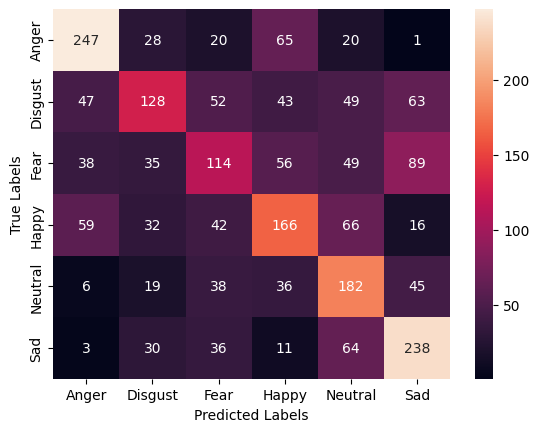

In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - FEA:
	F1-score = 0.3338	Precision = 0.3775	Recall = 0.2992 
2 - DIS:
	F1-score = 0.3914	Precision = 0.4706	Recall = 0.3351 
3 - HAP:
	F1-score = 0.4380	Precision = 0.4403	Recall = 0.4357 
4 - NEU:
	F1-score = 0.4815	Precision = 0.4233	Recall = 0.5583 
5 - SAD:
	F1-score = 0.5707	Precision = 0.5265	Recall = 0.6230 
6 - ANG:
	F1-score = 0.6325	Precision = 0.6175	Recall = 0.6483 


#### Another 1D model

In [ ]:
model = Sequential()
model.add(Conv1D(256, 12, activation='relu', input_shape=((np.concatenate((train_energy, train_zcr), axis=1)).shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(128, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
#model.add(Dense(128, activation='relu'))
#model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.0001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 303, 256)          3328      
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 151, 256)         0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 144, 128)          262272    
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 72, 128)          0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 68, 64)            41024     
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 34, 64)          

In [ ]:
history = model.fit(np.concatenate((train_energy, train_zcr), axis=1), y_train,
                    epochs=25,
                    batch_size=128,
                    validation_data=(np.concatenate((val_energy, val_zcr), axis=1), y_val))

Epoch 1/25
39/39 [==============================] - 46s 1s/step - loss: 1.7234 - accuracy: 0.2662 - val_loss: 1.7800 - val_accuracy: 0.3525
Epoch 2/25
39/39 [==============================] - 44s 1s/step - loss: 1.5988 - accuracy: 0.3516 - val_loss: 1.7661 - val_accuracy: 0.3908
Epoch 3/25
39/39 [==============================] - 45s 1s/step - loss: 1.5539 - accuracy: 0.3692 - val_loss: 1.7529 - val_accuracy: 0.4368
Epoch 4/25
39/39 [==============================] - 44s 1s/step - loss: 1.5163 - accuracy: 0.3815 - val_loss: 1.7410 - val_accuracy: 0.4100
Epoch 5/25
39/39 [==============================] - 44s 1s/step - loss: 1.5032 - accuracy: 0.3958 - val_loss: 1.7293 - val_accuracy: 0.3908
Epoch 6/25
39/39 [==============================] - 45s 1s/step - loss: 1.4869 - accuracy: 0.4025 - val_loss: 1.7148 - val_accuracy: 0.4330
Epoch 7/25
39/39 [==============================] - 45s 1s/step - loss: 1.4628 - accuracy: 0.4150 - val_loss: 1.6949 - val_accuracy: 0.4368
Epoch 8/25
39/39 [==

In [ ]:
y_pred = model.predict(np.concatenate((test_energy, test_zcr), axis=1))
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 4s 57ms/step


Acurracy score = 0.4601967799642218


F1 score (macro average) = 0.4343275560587625


F1 score (weighted average) = 0.4348376787576417


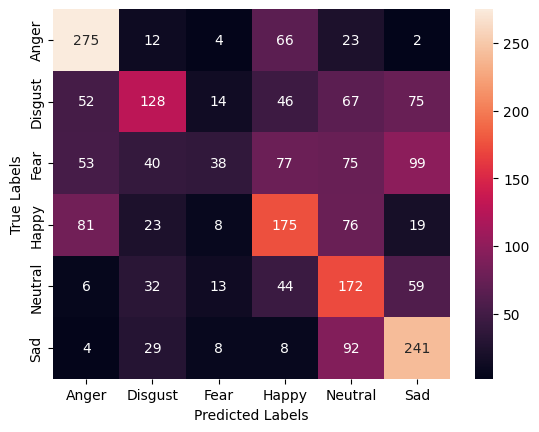

In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - FEA:
	F1-score = 0.2830	Precision = 0.3603	Recall = 0.2330 
2 - DIS:
	F1-score = 0.4060	Precision = 0.4770	Recall = 0.3534 
3 - HAP:
	F1-score = 0.4222	Precision = 0.3995	Recall = 0.4476 
4 - NEU:
	F1-score = 0.4255	Precision = 0.3756	Recall = 0.4908 
5 - SAD:
	F1-score = 0.5378	Precision = 0.4967	Recall = 0.5864 
6 - ANG:
	F1-score = 0.6539	Precision = 0.6384	Recall = 0.6702 


### Model 1D - MFCCs

#### Building Model

In [ ]:
model = Sequential()
model.add(Conv1D(16, 12, activation='relu', input_shape=(train_mfcc.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_21 (Conv1D)          (None, 146, 16)           208       
                                                                 
 max_pooling1d_21 (MaxPoolin  (None, 73, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_22 (Conv1D)          (None, 66, 24)            3096      
                                                                 
 max_pooling1d_22 (MaxPoolin  (None, 33, 24)           0         
 g1D)                                                            
                                                                 
 conv1d_23 (Conv1D)          (None, 29, 24)            2904      
                                                                 
 max_pooling1d_23 (MaxPoolin  (None, 14, 24)          

In [ ]:
history = model.fit(train_mfcc, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(val_mfcc, y_val))

Epoch 1/50
39/39 [==============================] - 2s 28ms/step - loss: 1.8826 - accuracy: 0.2005 - val_loss: 1.6890 - val_accuracy: 0.3295
Epoch 2/50
39/39 [==============================] - 1s 21ms/step - loss: 1.6468 - accuracy: 0.3116 - val_loss: 1.5244 - val_accuracy: 0.3448
Epoch 3/50
39/39 [==============================] - 1s 19ms/step - loss: 1.5765 - accuracy: 0.3448 - val_loss: 1.4620 - val_accuracy: 0.3678
Epoch 4/50
39/39 [==============================] - 1s 19ms/step - loss: 1.5453 - accuracy: 0.3624 - val_loss: 1.4599 - val_accuracy: 0.3410
Epoch 5/50
39/39 [==============================] - 1s 24ms/step - loss: 1.5281 - accuracy: 0.3654 - val_loss: 1.4324 - val_accuracy: 0.4138
Epoch 6/50
39/39 [==============================] - 1s 22ms/step - loss: 1.5076 - accuracy: 0.3759 - val_loss: 1.4440 - val_accuracy: 0.4138
Epoch 7/50
39/39 [==============================] - 1s 21ms/step - loss: 1.5019 - accuracy: 0.3834 - val_loss: 1.4227 - val_accuracy: 0.4176
Epoch 8/50
39

#### Evaluating Model

In [ ]:
y_pred = model.predict(test_mfcc)
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 0s 3ms/step


Acurracy score = 0.37214509628302733


F1 score (macro average) = 0.365114083038715


F1 score (weighted average) = 0.3663917421448286


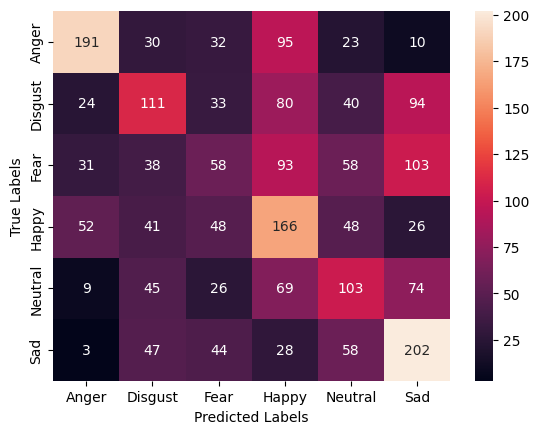

In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - FEA:
	F1-score = 0.1865	Precision = 0.2407	Recall = 0.1522 
2 - NEU:
	F1-score = 0.3140	Precision = 0.3121	Recall = 0.3160 
3 - DIS:
	F1-score = 0.3199	Precision = 0.3558	Recall = 0.2906 
4 - HAP:
	F1-score = 0.3640	Precision = 0.3126	Recall = 0.4357 
5 - SAD:
	F1-score = 0.4534	Precision = 0.3969	Recall = 0.5288 
6 - ANG:
	F1-score = 0.5528	Precision = 0.6161	Recall = 0.5013 


### Model 1D - Spectral Roll-off

This model gave us the worst results by far.

#### Building Model

In [ ]:
model = Sequential()
model.add(Conv1D(16, 12, activation='relu', input_shape=(train_sr.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_24 (Conv1D)          (None, 146, 16)           208       
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 73, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 66, 24)            3096      
                                                                 
 max_pooling1d_25 (MaxPoolin  (None, 33, 24)           0         
 g1D)                                                            
                                                                 
 conv1d_26 (Conv1D)          (None, 29, 24)            2904      
                                                                 
 max_pooling1d_26 (MaxPoolin  (None, 14, 24)          

In [ ]:
history = model.fit(train_sr, y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=(val_sr, y_val))

Epoch 1/50
39/39 [==============================] - 2s 27ms/step - loss: 179.7276 - accuracy: 0.1692 - val_loss: 19.6667 - val_accuracy: 0.2184
Epoch 2/50
39/39 [==============================] - 1s 21ms/step - loss: 14.7119 - accuracy: 0.1742 - val_loss: 6.2626 - val_accuracy: 0.1877
Epoch 3/50
39/39 [==============================] - 1s 22ms/step - loss: 5.3804 - accuracy: 0.1684 - val_loss: 3.2832 - val_accuracy: 0.1916
Epoch 4/50
39/39 [==============================] - 1s 22ms/step - loss: 2.7428 - accuracy: 0.1908 - val_loss: 2.2282 - val_accuracy: 0.1686
Epoch 5/50
39/39 [==============================] - 1s 21ms/step - loss: 2.0660 - accuracy: 0.1865 - val_loss: 1.9669 - val_accuracy: 0.1648
Epoch 6/50
39/39 [==============================] - 1s 22ms/step - loss: 1.9271 - accuracy: 0.1880 - val_loss: 1.9352 - val_accuracy: 0.1648
Epoch 7/50
39/39 [==============================] - 1s 22ms/step - loss: 1.8584 - accuracy: 0.1878 - val_loss: 1.9356 - val_accuracy: 0.1609
Epoch 8/5

#### Evaluating Model

In [ ]:
y_pred = model.predict(test_mfcc)
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 0s 4ms/step


Acurracy score = 0.17107030900134348


F1 score (macro average) = 0.04869343530911408


F1 score (weighted average) = 0.04998000614800245


In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - ANG:
	F1-score = nan	Precision = nan	Recall = 0.0000 
2 - DIS:
	F1-score = nan	Precision = nan	Recall = 0.0000 
3 - FEA:
	F1-score = nan	Precision = nan	Recall = 0.0000 
4 - HAP:
	F1-score = nan	Precision = nan	Recall = 0.0000 
5 - NEU:
	F1-score = nan	Precision = nan	Recall = 0.0000 
6 - SAD:
	F1-score = 0.2922	Precision = 0.1711	Recall = 1.0000 


/tmp/ipykernel_34/2911065269.py:13: RuntimeWarning: invalid value encountered in long_scalars
  precision = TP / (TP + FP)


### Model 1D - Energy, Zero Crossing Rate and MFCCs

#### Building Model

In [ ]:
model = Sequential()
model.add(Conv1D(16, 12, activation='relu', input_shape=((np.concatenate((train_mfcc,train_energy,train_zcr), axis=1)).shape[1], 1)))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 8, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Conv1D(24, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
#model.add(Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_27 (Conv1D)          (None, 460, 16)           208       
                                                                 
 max_pooling1d_27 (MaxPoolin  (None, 230, 16)          0         
 g1D)                                                            
                                                                 
 conv1d_28 (Conv1D)          (None, 223, 24)           3096      
                                                                 
 max_pooling1d_28 (MaxPoolin  (None, 111, 24)          0         
 g1D)                                                            
                                                                 
 conv1d_29 (Conv1D)          (None, 107, 24)           2904      
                                                                 
 max_pooling1d_29 (MaxPoolin  (None, 53, 24)          

In [ ]:
history = model.fit((np.concatenate((train_mfcc, train_energy,train_zcr), axis=1)), y_train,
                    epochs=50,
                    batch_size=128,
                    validation_data=((np.concatenate((val_mfcc,val_energy,val_zcr), axis=1)), y_val))

Epoch 1/50
39/39 [==============================] - 3s 53ms/step - loss: 2.0548 - accuracy: 0.1975 - val_loss: 1.7181 - val_accuracy: 0.2261
Epoch 2/50
39/39 [==============================] - 2s 44ms/step - loss: 1.6412 - accuracy: 0.3145 - val_loss: 1.5258 - val_accuracy: 0.3372
Epoch 3/50
39/39 [==============================] - 2s 45ms/step - loss: 1.5426 - accuracy: 0.3575 - val_loss: 1.4569 - val_accuracy: 0.3908
Epoch 4/50
39/39 [==============================] - 2s 45ms/step - loss: 1.5170 - accuracy: 0.3650 - val_loss: 1.3878 - val_accuracy: 0.4483
Epoch 5/50
39/39 [==============================] - 2s 44ms/step - loss: 1.4805 - accuracy: 0.3765 - val_loss: 1.3771 - val_accuracy: 0.4444
Epoch 6/50
39/39 [==============================] - 2s 44ms/step - loss: 1.4726 - accuracy: 0.3943 - val_loss: 1.3645 - val_accuracy: 0.4444
Epoch 7/50
39/39 [==============================] - 2s 54ms/step - loss: 1.4569 - accuracy: 0.3983 - val_loss: 1.3597 - val_accuracy: 0.4636
Epoch 8/50
39

#### Evaluating Model

In [ ]:
y_pred = model.predict((np.concatenate((test_mfcc, test_energy,test_zcr), axis=1)))
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 1s 6ms/step


Acurracy score = 0.44693237796686075


F1 score (macro average) = 0.4391544645220722


F1 score (weighted average) = 0.4391018836581617


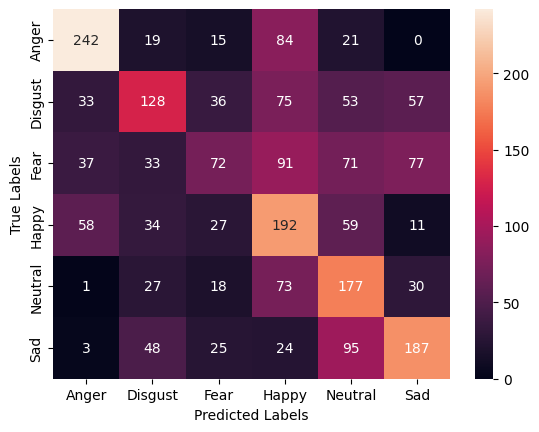

In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - FEA:
	F1-score = 0.2509	Precision = 0.3731	Recall = 0.1890 
2 - DIS:
	F1-score = 0.3815	Precision = 0.4429	Recall = 0.3351 
3 - HAP:
	F1-score = 0.4174	Precision = 0.3562	Recall = 0.5039 
4 - NEU:
	F1-score = 0.4414	Precision = 0.3718	Recall = 0.5429 
5 - SAD:
	F1-score = 0.5027	Precision = 0.5166	Recall = 0.4895 
6 - ANG:
	F1-score = 0.6411	Precision = 0.6471	Recall = 0.6352 


### Model 2D - Mel Spectrogram

#### Building Model

We build our own model but we have noticed that the accuracy not so good as shown.

In [ ]:

model = Sequential()
model.add(Conv2D(16, (7, 7), activation='relu', input_shape=(train_mel.shape[1], train_mel.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(24, (7, 7), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(BatchNormalization())
model.add(Conv2D(24, (7, 7), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.00001)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.00001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 122, 151, 16)      800       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 61, 75, 16)       0         
 2D)                                                             
                                                                 
 batch_normalization_3 (Batc  (None, 61, 75, 16)       64        
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 55, 69, 24)        18840     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 27, 34, 24)       0         
 2D)                                                             
                                                      

In [ ]:
history = model.fit(train_mel, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(val_mel, y_val))

Epoch 1/10
39/39 [==============================] - 229s 6s/step - loss: 2.3071 - accuracy: 0.1964 - val_loss: 2.3234 - val_accuracy: 0.2031
Epoch 2/10
39/39 [==============================] - 222s 6s/step - loss: 1.9433 - accuracy: 0.2920 - val_loss: 2.2687 - val_accuracy: 0.2069
Epoch 3/10
39/39 [==============================] - 223s 6s/step - loss: 1.7613 - accuracy: 0.3472 - val_loss: 2.1264 - val_accuracy: 0.2222
Epoch 4/10
39/39 [==============================] - 223s 6s/step - loss: 1.6761 - accuracy: 0.3707 - val_loss: 1.9395 - val_accuracy: 0.2529
Epoch 5/10
39/39 [==============================] - 223s 6s/step - loss: 1.6030 - accuracy: 0.3941 - val_loss: 1.7752 - val_accuracy: 0.3103
Epoch 6/10
39/39 [==============================] - 221s 6s/step - loss: 1.5754 - accuracy: 0.3957 - val_loss: 1.6510 - val_accuracy: 0.3602
Epoch 7/10
39/39 [==============================] - 226s 6s/step - loss: 1.5214 - accuracy: 0.4194 - val_loss: 1.6229 - val_accuracy: 0.3870
Epoch 8/10
39

#### Evaluating Model

In [ ]:
y_pred = model.predict(test_mel)
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 26s 365ms/step


Acurracy score = 0.4025974025974026


F1 score (macro average) = 0.37678596107610596


F1 score (weighted average) = 0.3772434861554859


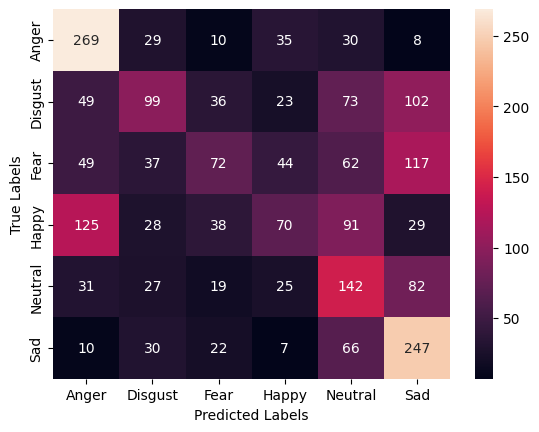

In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - FEA:
	F1-score = 0.2665	Precision = 0.2934	Recall = 0.2441 
2 - DIS:
	F1-score = 0.2778	Precision = 0.3696	Recall = 0.2225 
3 - NEU:
	F1-score = 0.3156	Precision = 0.4150	Recall = 0.2546 
4 - HAP:
	F1-score = 0.3703	Precision = 0.3679	Recall = 0.3727 
5 - SAD:
	F1-score = 0.4513	Precision = 0.4422	Recall = 0.4607 
6 - ANG:
	F1-score = 0.5485	Precision = 0.4231	Recall = 0.7795 


### Model 2D - Research Paper

This model is replicated from a model in this research paper with some modifications and it gives higher accuracy and less confusing classes.

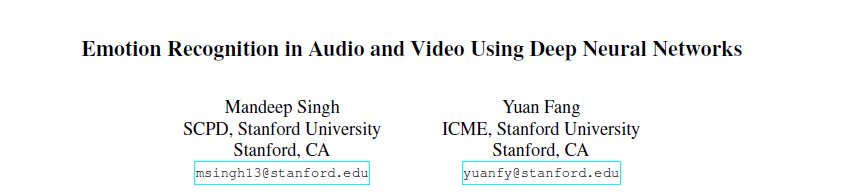

#### Building Model

This was the CNN model architecture used in the original research paper, we have replicated it here. However, since the research paper was used on a different dataset, we have modified the input and output layers accordingly.

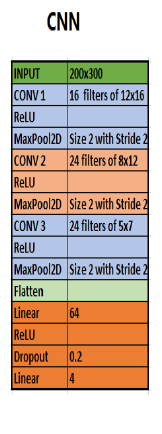

In [ ]:
model = Sequential()
model.add(Conv2D(16, (12, 6), activation='relu', input_shape=(train_mel.shape[1], train_mel.shape[2], 1)))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(24, (8, 12), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Conv2D(24, (5, 7), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.001),
             metrics=['accuracy'])

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 117, 152, 16)      1168      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 58, 76, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 51, 65, 24)        36888     
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 25, 32, 24)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 21, 26, 24)        20184     
                                                                 
 flatten_18 (Flatten)        (None, 13104)           

In [ ]:
history = model.fit(train_mel, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(val_mel, y_val))

Epoch 1/10
39/39 [==============================] - 155s 4s/step - loss: 3.2869 - accuracy: 0.1776 - val_loss: 1.7848 - val_accuracy: 0.2184
Epoch 2/10
39/39 [==============================] - 154s 4s/step - loss: 1.7462 - accuracy: 0.2478 - val_loss: 1.5522 - val_accuracy: 0.3333
Epoch 3/10
39/39 [==============================] - 154s 4s/step - loss: 1.5277 - accuracy: 0.3832 - val_loss: 1.3663 - val_accuracy: 0.4483
Epoch 4/10
39/39 [==============================] - 154s 4s/step - loss: 1.3874 - accuracy: 0.4464 - val_loss: 1.3026 - val_accuracy: 0.4598
Epoch 5/10
39/39 [==============================] - 153s 4s/step - loss: 1.3019 - accuracy: 0.4893 - val_loss: 1.3870 - val_accuracy: 0.4521
Epoch 6/10
39/39 [==============================] - 154s 4s/step - loss: 1.2287 - accuracy: 0.5253 - val_loss: 1.2957 - val_accuracy: 0.4444
Epoch 7/10
39/39 [==============================] - 156s 4s/step - loss: 1.1668 - accuracy: 0.5451 - val_loss: 1.2497 - val_accuracy: 0.4713
Epoch 8/10
39

#### Evaluating Model

In [ ]:
y_pred = model.predict(test_mel)
print("\n")
print("Acurracy score =",accuracy_score(y_test.argmax(axis=1),y_pred.argmax(axis=1)))
print("\n")
print("F1 score (macro average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'macro'))
print("\n")
print("F1 score (weighted average) =",f1_score(y_test.argmax(axis=1),y_pred.argmax(axis=1),average = 'weighted'))

70/70 [==============================] - 15s 208ms/step


Acurracy score = 0.46618898343036275


F1 score (macro average) = 0.4614819803410712


F1 score (weighted average) = 0.46092974621199106


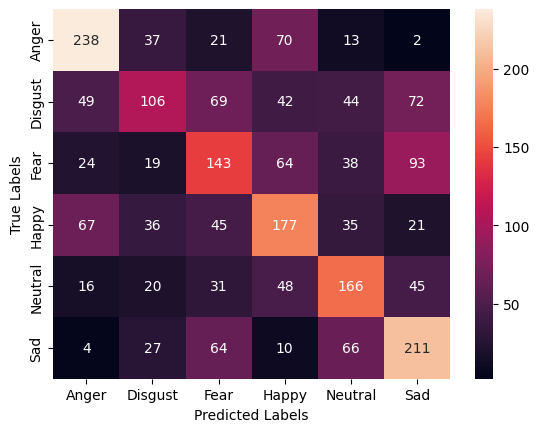

In [ ]:
con_mat = confusion_matrix(y_test.argmax(axis=1),y_pred.argmax(axis=1))
#unique_labels = np.unique(labels)
#print(unique_labels)
ax = sns.heatmap(con_mat, annot=True, fmt="d",
                 xticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'],
                 yticklabels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad'])
#ax = sns.heatmap(con_mat, annot=True, fmt="d", xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [ ]:
class_labels = list(np.unique(labels))
#print(class_labels)

precisions = []
recalls = []
f1_scores = []

for i in range(len(class_labels)):
    TP = con_mat[i, i]
    FP = np.sum(con_mat[:, i]) - TP
    FN = np.sum(con_mat[i, :]) - TP
    
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2 * (precision * recall) / (precision + recall)
    
    precisions.append(precision)
    recalls.append(recall)
    f1_scores.append(f1)

#print(f1_scores)
#print(precisions)
#print(recalls)

class_idxs = list(range(len(class_labels)))
sorted_classes = sorted(class_idxs, key=lambda x: f1_scores[x])

k=1
print("Most Confusing Classes:\n")
for j in sorted_classes:
    label = class_labels[j]
    print(f"{k} - {label}:\n\tF1-score = {f1_scores[j]:.4f}\tPrecision = {precisions[j]:.4f}\tRecall = {recalls[j]:.4f} ")
    k+=1

Most Confusing Classes:

1 - DIS:
	F1-score = 0.3381	Precision = 0.4327	Recall = 0.2775 
2 - FEA:
	F1-score = 0.3793	Precision = 0.3834	Recall = 0.3753 
3 - HAP:
	F1-score = 0.4470	Precision = 0.4307	Recall = 0.4646 
4 - NEU:
	F1-score = 0.4826	Precision = 0.4586	Recall = 0.5092 
5 - SAD:
	F1-score = 0.5109	Precision = 0.4752	Recall = 0.5524 
6 - ANG:
	F1-score = 0.6110	Precision = 0.5980	Recall = 0.6247 


These were the results obtained in the original paper, note that the datasets used were different, so labels and accuracies will also be slightly different

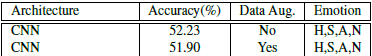

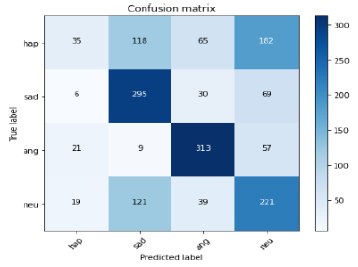